In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Specify working directory.
FOLDERNAME = 'cs231n/project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

# Ensure that the Python interpreter of the Colab VM can load python files from
# within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive
/content/drive/My Drive/cs231n/project


## Load dataset and labels

In [2]:
import numpy as np
import os

base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'

train_data = np.load(os.path.join(base_dir, 'test_data_pre60.npy'))
train_labels = np.load(os.path.join(base_dir, 'test_labels_pre60.npy'))
train_actions = np.load(os.path.join(base_dir, 'test_actions_pre60.npy'), allow_pickle=True)

val_labels = np.load(os.path.join(base_dir, 'val_labels_pre60.npy'))
val_data = np.load(os.path.join(base_dir, 'val_data_pre60.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre60.npy'), allow_pickle=True)

In [3]:
# reshape data
train_data = np.moveaxis(train_data, 2, -1)
val_data = np.moveaxis(val_data, 2, -1)

In [4]:
print('Training data shape: ', train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Training action shape: ', train_actions.shape)
print('Train Label=1 ratio:', np.sum(train_labels) /train_labels.shape[0])
print('Validation data shape: ', val_data.shape)
print('Validation label shape: ', val_labels.shape)
print('Validation action shape: ', val_actions.shape)
print('Validation Label=1 ratio:', np.sum(val_labels) / val_labels.shape[0])

Training data shape:  (480, 60, 64, 48, 17)
Training label shape:  (480,)
Training action shape:  (480,)
Train Label=1 ratio: 0.25
Validation data shape:  (433, 60, 64, 48, 17)
Validation label shape:  (433,)
Validation action shape:  (433,)
Validation Label=1 ratio: 0.2517321016166282


In [5]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

## Model 1: HR-Net + LSTM

In [6]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, Masking
from keras import models

# feature: (x, 60, 64, 48, 17)
special_value = -10
model = models.Sequential()
model.add(Input(shape=(60, 64, 48, 17)))
model.add(TimeDistributed(Flatten()))
#model.add(Dropout(0.2))

model.add(Masking(mask_value=special_value))
model.add(LSTM(32, return_sequences=False, dropout=0.2)) # used 32 units

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 60, 52224)         0         
_________________________________________________________________
masking (Masking)            (None, 60, 52224)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3343424   
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2

In [7]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=5),
                  keras.callbacks.ModelCheckpoint(
                      filepath='hrnet_lstm_model_v1',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=3
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [8]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=10, epochs=50,
                    callbacks=callbacks_list
                    )

Epoch 1/50
48/48 [==============================] - 35s 627ms/step - loss: 2.0790 - accuracy: 0.1628 - val_loss: 2.0744 - val_accuracy: 0.1663


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 2/50
48/48 [==============================] - 7s 138ms/step - loss: 2.0527 - accuracy: 0.2101 - val_loss: 2.0402 - val_accuracy: 0.2079


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 3/50
48/48 [==============================] - 7s 141ms/step - loss: 1.9821 - accuracy: 0.2583 - val_loss: 2.0109 - val_accuracy: 0.2171


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 4/50
48/48 [==============================] - 7s 143ms/step - loss: 1.9185 - accuracy: 0.2937 - val_loss: 1.9983 - val_accuracy: 0.2309


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 5/50
48/48 [==============================] - 7s 140ms/step - loss: 1.8681 - accuracy: 0.3197 - val_loss: 1.9429 - val_accuracy: 0.2448


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 6/50
48/48 [==============================] - 7s 139ms/step - loss: 1.7669 - accuracy: 0.3827 - val_loss: 1.9197 - val_accuracy: 0.2494


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 7/50
48/48 [==============================] - 7s 141ms/step - loss: 1.6963 - accuracy: 0.4131 - val_loss: 1.8606 - val_accuracy: 0.3210


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 8/50
48/48 [==============================] - 7s 141ms/step - loss: 1.6141 - accuracy: 0.4413 - val_loss: 1.7874 - val_accuracy: 0.3395


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 9/50
48/48 [==============================] - 7s 141ms/step - loss: 1.4776 - accuracy: 0.5323 - val_loss: 1.7468 - val_accuracy: 0.3626


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 10/50
48/48 [==============================] - 7s 141ms/step - loss: 1.4067 - accuracy: 0.5777 - val_loss: 1.8247 - val_accuracy: 0.3533
Epoch 11/50
48/48 [==============================] - 7s 141ms/step - loss: 1.3634 - accuracy: 0.5612 - val_loss: 1.7315 - val_accuracy: 0.3764


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 12/50
48/48 [==============================] - 7s 141ms/step - loss: 1.2914 - accuracy: 0.6193 - val_loss: 1.6855 - val_accuracy: 0.3857


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 13/50
48/48 [==============================] - 7s 138ms/step - loss: 1.1351 - accuracy: 0.6455 - val_loss: 1.7031 - val_accuracy: 0.3811
Epoch 14/50
48/48 [==============================] - 7s 141ms/step - loss: 0.9886 - accuracy: 0.7503 - val_loss: 1.6704 - val_accuracy: 0.4065


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 15/50
48/48 [==============================] - 7s 140ms/step - loss: 0.9982 - accuracy: 0.7077 - val_loss: 1.6675 - val_accuracy: 0.4642


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 16/50
48/48 [==============================] - 7s 141ms/step - loss: 0.9644 - accuracy: 0.7209 - val_loss: 1.6006 - val_accuracy: 0.4642


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 17/50
48/48 [==============================] - 7s 138ms/step - loss: 0.8158 - accuracy: 0.7956 - val_loss: 1.5606 - val_accuracy: 0.4734


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 18/50
48/48 [==============================] - 7s 141ms/step - loss: 0.7633 - accuracy: 0.8272 - val_loss: 1.5824 - val_accuracy: 0.4665
Epoch 19/50
48/48 [==============================] - 7s 140ms/step - loss: 0.7313 - accuracy: 0.8220 - val_loss: 1.5602 - val_accuracy: 0.4596


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 20/50
48/48 [==============================] - 7s 140ms/step - loss: 0.6997 - accuracy: 0.8396 - val_loss: 1.6598 - val_accuracy: 0.4319
Epoch 21/50
48/48 [==============================] - 7s 143ms/step - loss: 0.6548 - accuracy: 0.8362 - val_loss: 1.5824 - val_accuracy: 0.4758
Epoch 22/50
48/48 [==============================] - 7s 141ms/step - loss: 0.5713 - accuracy: 0.8472 - val_loss: 1.5382 - val_accuracy: 0.4896


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 23/50
48/48 [==============================] - 7s 139ms/step - loss: 0.5195 - accuracy: 0.9005 - val_loss: 1.5497 - val_accuracy: 0.4804
Epoch 24/50
48/48 [==============================] - 7s 142ms/step - loss: 0.5220 - accuracy: 0.8697 - val_loss: 1.5083 - val_accuracy: 0.4850


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 25/50
48/48 [==============================] - 7s 141ms/step - loss: 0.4571 - accuracy: 0.8964 - val_loss: 1.5728 - val_accuracy: 0.4596
Epoch 26/50
48/48 [==============================] - 7s 143ms/step - loss: 0.5036 - accuracy: 0.8873 - val_loss: 1.6646 - val_accuracy: 0.4642
Epoch 27/50
48/48 [==============================] - 7s 142ms/step - loss: 0.4265 - accuracy: 0.9320 - val_loss: 1.5832 - val_accuracy: 0.4942
Epoch 28/50
48/48 [==============================] - 7s 142ms/step - loss: 0.3399 - accuracy: 0.9414 - val_loss: 1.5924 - val_accuracy: 0.4919
Epoch 29/50
48/48 [==============================] - 7s 142ms/step - loss: 0.3726 - accuracy: 0.9292 - val_loss: 1.6032 - val_accuracy: 0.4850
Epoch 30/50
48/48 [==============================] - 7s 138ms/step - loss: 0.3458 - accuracy: 0.9226 - val_loss: 1.6065 - val_accuracy: 0.4850
Epoch 31/50
48/48 [==============================] - 7s 142ms/step - loss: 0.3280 - accuracy: 0.9483 - val_loss: 1.6068 - val_accuracy: 0.4873

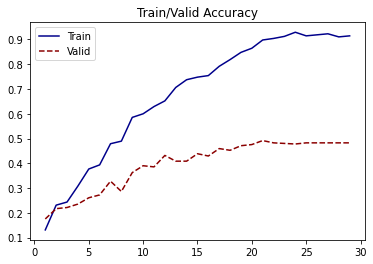

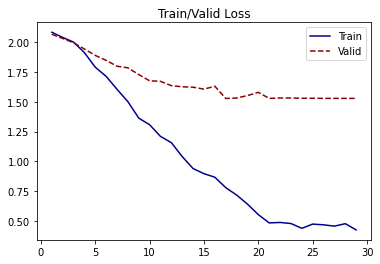

In [10]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkblue')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'darkblue')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

## Model 2: HR-Net + CNN + LSTM

In [6]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, Masking
from keras import models

# feature: (x, 60, 64, 48, 17)
model = models.Sequential()
model.add(Input(shape=(60, 64, 48, 17)))
model.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False, dropout=0.2)) # used 32 units

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 60, 62, 46, 64)    9856      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 60, 44, 64)    36928     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 60, 58, 42, 32)    18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 60, 56, 40, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 60, 56, 40, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 60, 71680)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 71680)         0

In [7]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=5),
                  keras.callbacks.ModelCheckpoint(
                      filepath='hrnet_cnn_lstm_model_v1',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=3
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [8]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=10, epochs=50,
                    callbacks=callbacks_list
                    )

Epoch 1/50
44/44 [==============================] - 40s 467ms/step - loss: 2.1090 - accuracy: 0.1121 - val_loss: 2.0830 - val_accuracy: 0.1250


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 2/50
44/44 [==============================] - 11s 257ms/step - loss: 2.0756 - accuracy: 0.1672 - val_loss: 2.0818 - val_accuracy: 0.1250


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 3/50
44/44 [==============================] - 11s 257ms/step - loss: 2.0880 - accuracy: 0.0782 - val_loss: 2.0800 - val_accuracy: 0.1312


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 4/50
44/44 [==============================] - 11s 256ms/step - loss: 2.0691 - accuracy: 0.1736 - val_loss: 2.0824 - val_accuracy: 0.1250
Epoch 5/50
44/44 [==============================] - 11s 256ms/step - loss: 2.0661 - accuracy: 0.1602 - val_loss: 2.0842 - val_accuracy: 0.1250
Epoch 6/50
44/44 [==============================] - 11s 258ms/step - loss: 2.0434 - accuracy: 0.1720 - val_loss: 2.0711 - val_accuracy: 0.1458


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 7/50
44/44 [==============================] - 11s 255ms/step - loss: 2.0279 - accuracy: 0.1812 - val_loss: 2.0487 - val_accuracy: 0.1896


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 8/50
44/44 [==============================] - 11s 260ms/step - loss: 1.9774 - accuracy: 0.2549 - val_loss: 2.0386 - val_accuracy: 0.1896


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 9/50
44/44 [==============================] - 11s 256ms/step - loss: 1.9577 - accuracy: 0.2118 - val_loss: 2.0338 - val_accuracy: 0.1896


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 10/50
44/44 [==============================] - 11s 257ms/step - loss: 1.9408 - accuracy: 0.2590 - val_loss: 2.0282 - val_accuracy: 0.2021


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 11/50
44/44 [==============================] - 11s 257ms/step - loss: 1.9056 - accuracy: 0.2284 - val_loss: 1.9935 - val_accuracy: 0.1896


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 12/50
44/44 [==============================] - 11s 256ms/step - loss: 1.9057 - accuracy: 0.2565 - val_loss: 1.9576 - val_accuracy: 0.2292


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 13/50
44/44 [==============================] - 11s 257ms/step - loss: 1.8468 - accuracy: 0.2958 - val_loss: 1.9860 - val_accuracy: 0.2438
Epoch 14/50
44/44 [==============================] - 11s 257ms/step - loss: 1.8223 - accuracy: 0.3009 - val_loss: 1.9712 - val_accuracy: 0.2229
Epoch 15/50
44/44 [==============================] - 11s 256ms/step - loss: 1.7839 - accuracy: 0.3079 - val_loss: 1.9500 - val_accuracy: 0.2313


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 16/50
44/44 [==============================] - 11s 257ms/step - loss: 1.7583 - accuracy: 0.3614 - val_loss: 1.9544 - val_accuracy: 0.2458
Epoch 17/50
44/44 [==============================] - 11s 255ms/step - loss: 1.7249 - accuracy: 0.3950 - val_loss: 1.9478 - val_accuracy: 0.2271


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 18/50
44/44 [==============================] - 11s 257ms/step - loss: 1.6909 - accuracy: 0.3708 - val_loss: 1.9424 - val_accuracy: 0.2396


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_cnn_lstm_model_v1/assets


Epoch 19/50
44/44 [==============================] - 11s 258ms/step - loss: 1.6662 - accuracy: 0.4261 - val_loss: 1.9634 - val_accuracy: 0.2062
Epoch 20/50
44/44 [==============================] - 11s 256ms/step - loss: 1.6821 - accuracy: 0.4308 - val_loss: 1.9521 - val_accuracy: 0.2167
Epoch 21/50
44/44 [==============================] - 11s 255ms/step - loss: 1.6033 - accuracy: 0.4436 - val_loss: 1.9476 - val_accuracy: 0.2146
Epoch 22/50
44/44 [==============================] - 11s 255ms/step - loss: 1.5262 - accuracy: 0.5188 - val_loss: 1.9522 - val_accuracy: 0.2188
Epoch 23/50
44/44 [==============================] - 11s 256ms/step - loss: 1.5793 - accuracy: 0.4894 - val_loss: 1.9562 - val_accuracy: 0.2375
Epoch 24/50
44/44 [==============================] - 11s 257ms/step - loss: 1.5321 - accuracy: 0.5455 - val_loss: 1.9520 - val_accuracy: 0.2313
Epoch 25/50
44/44 [==============================] - 11s 256ms/step - loss: 1.5351 - accuracy: 0.5122 - val_loss: 1.9520 - val_accuracy:

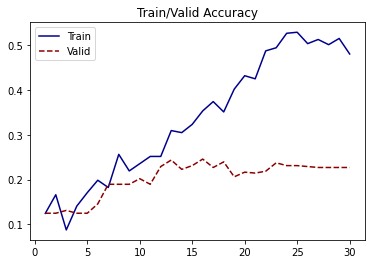

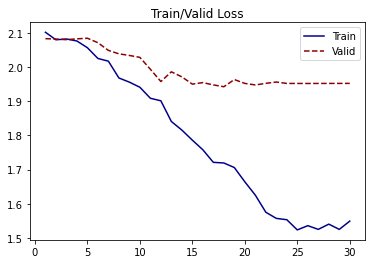

In [9]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkblue')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'darkblue')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

## Evaluate model on test dataset

In [ ]:
base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_data'

test_data = np.load(os.path.join(base_dir, 'test_data.npy'))
text_labels = np.load(os.path.join(base_dir, 'test_labels.npy'))

In [ ]:
# Evaluate on test dataset.
model = load_model('cnn_lstm_model_v1')
model.evaluate(test_data, test_labels)

In [ ]:
# preds = model.predict_classes(X_test)
# print(classification_report(train_labels, preds))